## Лабораторная 3: метод ближайших соседей (kNN)

В рамках этого занятия мы будем создавать модель для предсказания выживших пассажиров на "Титанике" (классическое учебное Kaggle [соревнование](https://www.kaggle.com/c/titanic)).

![Титаник](http://staff.mmcs.sfedu.ru/~sguda/MachineLearning/titanic.png)

## 1

Загрузите данные о погибших в катастрофе с "Титаником". Целевым признаком здесь является факт спасения пассажира. Посмотрите на данные.

In [50]:
import pandas as pd

In [51]:
table = pd.read_csv('data.csv')

In [3]:
table

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
# место для кода

Для простоты исключите пассажиров с неизвестным возрастом и заново перенумеруйте строки

*Функции, которые могут пригодиться при решении: `.dropna(subset='Age'), .reset_index(drop=True)`*

In [52]:
table.dropna(subset=['Age'], inplace=True)
table.reset_index(drop=True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
709,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
710,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
711,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
712,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 2

Постройте график рассеяния с возрастом в качестве оси абсцисс и ценой билета в качестве оси ординат. Отметьте красным — погибших, зеленым — спасшихся пассажиров. Постройте отдельно 2 графика: для женщин и для мужчин. 

Выполняется ли для данного множества гипотеза компактности?

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

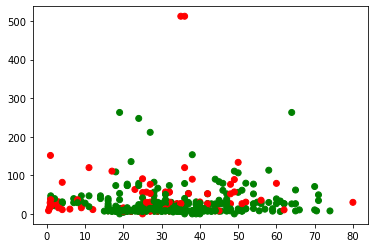

In [11]:
color_dict = {0: 'g', 1: 'r'}
table_male = table.loc[table['Sex'] == 'male']
color_arr = table_male.Survived.map(color_dict)
plt.scatter(table_male.Age , table_male.Fare , c=color_arr)
plt.show()

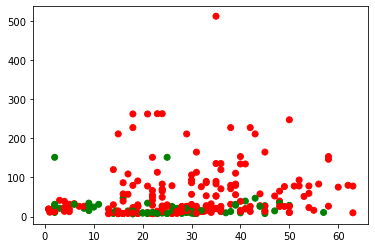

In [12]:
table_female = table.loc[table['Sex'] == 'female']
color_arr = table_female.Survived.map(color_dict)
plt.scatter(table_female.Age , table_female.Fare , c=color_arr)
plt.show()

## 3 

Для построения модели нам понадобится метрика близости пассажиров. Запрограммируем функцию вычисления расстояния между пассажирами:

In [91]:
def distance(a,b):
    d = 0
    d += 5 * abs(a['Pclass'] - b['Pclass'])
    d += 10 * (a['Sex'] != b['Sex'])
    d += 8 * abs(a['Age'] - b['Age'])
    d += abs(a['SibSp'] - b['SibSp'])
    d += abs(a['Parch'] - b['Parch'])
    d += abs(a['Fare'] - b['Fare'])
    d += a['Embarked'] != b['Embarked']
    return d

Метод `KNeighborsClassifier` из библиотеки `sklearn` излишне требователен к типам данных. Запрограммируем метод `k` ближайших соседей вручную:

In [15]:
import numpy as np
import tqdm

In [92]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    return round(prediction)

Запустите предсказание для всех пассажиров судна и, используя LOO-контроль ошибки оцените качество классификации:

In [ ]:
accuracy = 0
for idx, row in tqdm.tqdm(table.iterrows(), total=len(table)):
    accuracy += row['Survived'] == myKNeighborsClassifier(table, 7, idx)
print(accuracy/table.shape[0])

# default metric L1 = 0.726890756302521
# Euclidean metric = 0.6834733893557423
# L-int metric = 0.6582633053221288
# Canberra metric = 0.47478991596638653
# Lance-Williams metric = 0.7282913165266106

# default metric L1 = 0.7282913165266106
# Lance-Williams metric with 7 neigh = 0.7394957983193278

# weighted default metric L1 with 7 neigh = 0.7464985994397759
# weighted Lance-Williams metric with 7 neigh = 0.7535014005602241

# 2 weighted Lance-Williams metric with 7 neih = 0.7633053221288515

 64%|██████████████████████████████████████████████████▉                             | 455/714 [02:46<01:21,  3.17it/s]

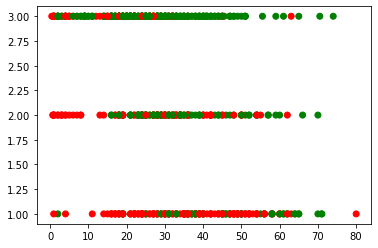

In [84]:
# подбор метрик
table_my = table
color_arr = table_my.Survived.map(color_dict)
# table_my.dropna(subset=['Cabin'], inplace=False)
plt.scatter(table_my.Age , table_my.Pclass , c=color_arr)
plt.show()

In [48]:
import math

def distance(a,b): # Euclidean
    d = 0
    d += pow(a['Pclass'] - b['Pclass'], 2) #ok
    d += a['Sex'] != b['Sex'] #ok
    d += pow(a['Age'] - b['Age'], 2)
    d += pow(a['SibSp'] - b['SibSp'], 2)
    d += pow(a['Parch'] - b['Parch'], 2)
    d += pow(a['Fare'] - b['Fare'], 2)
    d += a['Embarked'] != b['Embarked']
    return math.sqrt(d)

In [62]:
def distance(a,b): #L_inf
    i1 = abs(a['Pclass'] - b['Pclass']) 
#     i = a['Sex'] != b['Sex'] 
    i2 = abs(a['Age'] - b['Age'])
    i3 = abs(a['SibSp'] - b['SibSp'])
    i4 = abs(a['Parch'] - b['Parch'])
    i5 = abs(a['Fare'] - b['Fare'])
#     i7 = a['Embarked'] != b['Embarked']
    return max(i1,i2,i3,i4,i5)

In [68]:
def distance(a,b): #Canberra
    d = 0
    d += abs(a['Pclass'] - b['Pclass']) / (a['Pclass'] + b['Pclass'])
    d += a['Sex'] != b['Sex']
    d += abs(a['Age'] - b['Age']) / (a['Age'] + b['Age'])
    d += abs(a['SibSp'] - b['SibSp']) / (a['SibSp'] + b['SibSp'])
    d += abs(a['Parch'] - b['Parch']) / (a['Parch'] + b['Parch'])
    d += abs(a['Fare'] - b['Fare']) / (a['Fare'] + b['Fare'])
    d += a['Embarked'] != b['Embarked']
    return d / 7

In [87]:
def distance(a,b): #Lance-Williams
    up = 0
    down = 0
    up += 5 * abs(a['Pclass'] - b['Pclass'])
    up += 10 *(a['Sex'] != b['Sex'])
    up += 8 * abs(a['Age'] - b['Age'])
    up += abs(a['SibSp'] - b['SibSp'])
    up += abs(a['Parch'] - b['Parch'])
    up += abs(a['Fare'] - b['Fare'])
    up += a['Embarked'] != b['Embarked']
    
    down += 5 * (a['Pclass'] + b['Pclass'])
    down += 10 * (a['Sex'] == b['Sex'])
    down += 8 * (a['Age'] + b['Age'])
    down += (a['SibSp'] + b['SibSp'])
    down += (a['Parch'] + b['Parch'])
    down += (a['Fare'] + b['Fare'])
    down += a['Embarked'] == b['Embarked']
    return up / down

## 4

Создайте копию функции `myKNeighborsClassifier` и измените ее так, чтобы она считала выступ объекта. Назовите ее `calcMargin`. 

Вычислите выступы для всех объектов и выведите информацию о пяти объектах с минимальным выступом (шумовых выбросах) и пяти объектах с максимальным выступом (эталонах). Объясните в комментариях полученные данные.

Подберите слагаемые в метрике, их веса и количество соседей так, чтобы качество классификации было максимальным. 

Если функция на `python` работает долго, воспользуйтесь ее аналогом на 
С++:  `KNeighborsClassifier.cpp.` 

Компиляция на Linux выполняется командой 

    g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier


Запуск: 

    ./KNeighborsClassifier
    
Построившему метрику с наилучшим качеством: +5 бонусных баллов.

In [ ]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    return round(prediction)

In [ ]:
# место для кода

In [ ]:
# место для кода

Это легче всего сделать с помощью функции `np.argsort`, возвращающей индексы элементов в отсортированном ряду:

In [ ]:
idx = np.argsort(margins)

In [ ]:
print('Белые вороны (аномалии)')
data.loc[idx[:5],]

In [ ]:
print('Эталоны (характерные объекты)')
data.loc[idx[-5:],]